# Histopathologic Cancer Detection

Kaggle mini competition: https://www.kaggle.com/competitions/histopathologic-cancer-detection/submissions

### Exploratory Data Analysis

In [65]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [66]:
# let's first take a look at labels

train_labels = pd.read_csv('./train_labels.csv')

print(train_labels.head())
print(train_labels.shape)

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
(220025, 2)


In [67]:
samples = pd.read_csv('./sample_submission.csv')

print(samples.head())
print(samples.shape)

                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0
(57458, 2)


In [68]:
# Duplicates
print(f"Duplicates: {train_labels.duplicated().sum()}")

# Null values
print(f"Null vals: {train_labels.isnull().sum()}")

Duplicates: 0
Null vals: id       0
label    0
dtype: int64


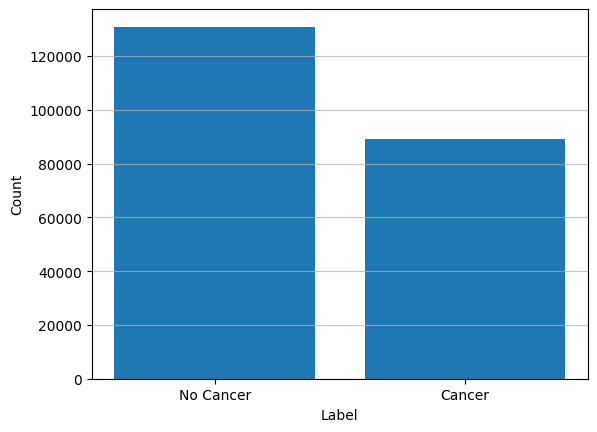

In [69]:
# plotting cases on histogram
plt.hist(train_labels['label'], bins=[-0.5, 0.5, 1.5], rwidth=0.8)

plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Cancer', 'Cancer'])

plt.grid(axis='y', alpha=0.75)
plt.show()

In [70]:
train = "./train"
test = "./test"
print("Number of training images: {}".format(len(os.listdir(train))))
print("Number of test images: {}".format(len(os.listdir(test))))

Number of training images: 220025
Number of test images: 57458


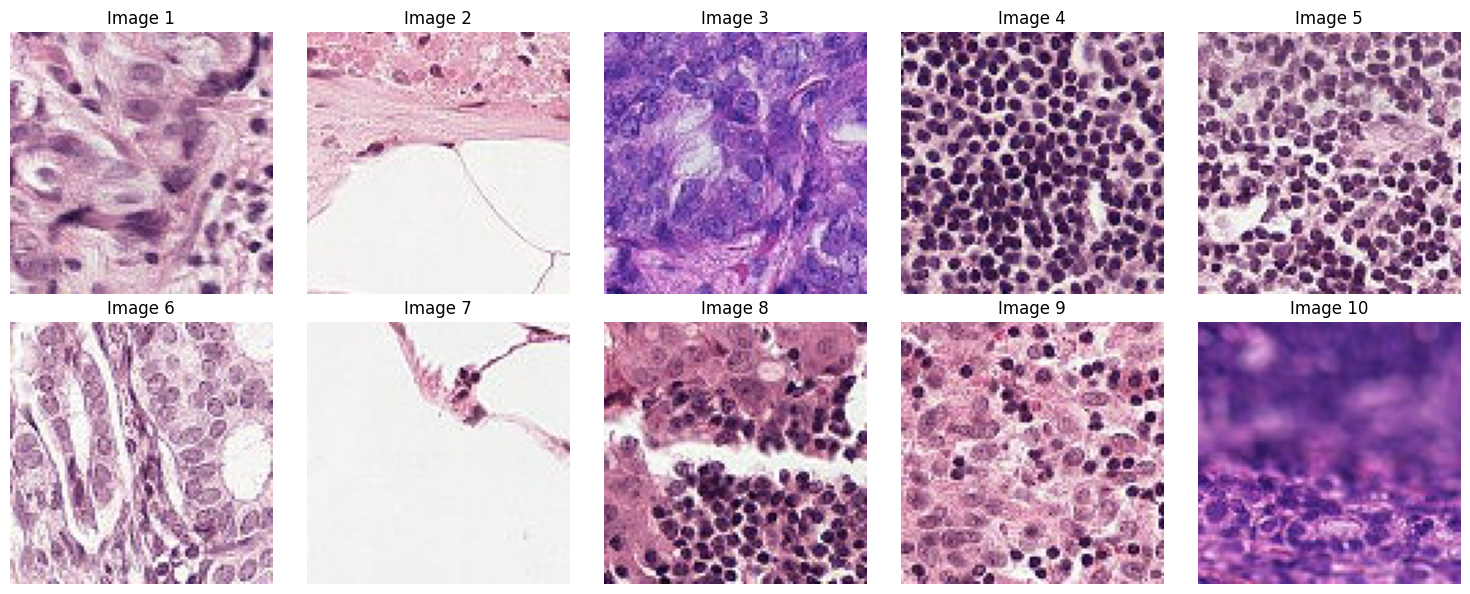

In [71]:
def display_random_images(image_dir, num_images=10, rows=2, cols=5):
    image_ids = os.listdir(image_dir)
    np.random.shuffle(image_ids)
    image_ids = image_ids[:num_images]
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    
    for i, filename in enumerate(image_ids):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        row = i // cols
        col = i % cols
        
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Image {i+1}')
    
    plt.tight_layout()
    plt.show()

display_random_images(train)

In [72]:
def plot_fig(ids, title, train_dir, nrows=5, ncols=10):

    fig, ax = plt.subplots(nrows, ncols, figsize=(18, 6))
    plt.subplots_adjust(wspace=0, hspace=0) 
    
    for i, j in enumerate(ids[:nrows * ncols]):
        fname = os.path.join(train_dir, j + '.tif')
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        cv2.rectangle(img, (0, 0), (95, 95), (255, 255, 255), 1)
        
        ax[i // ncols, i % ncols].imshow(img)
        ax[i // ncols, i % ncols].axis('off')

    plt.suptitle(title, y=0.94)
    plt.show()

# Checking images with and without cancer
cancer = train_labels.loc[train_labels['label']==1]['id'].values 
non_cancer = train_labels.loc[train_labels['label']==0]['id'].values 

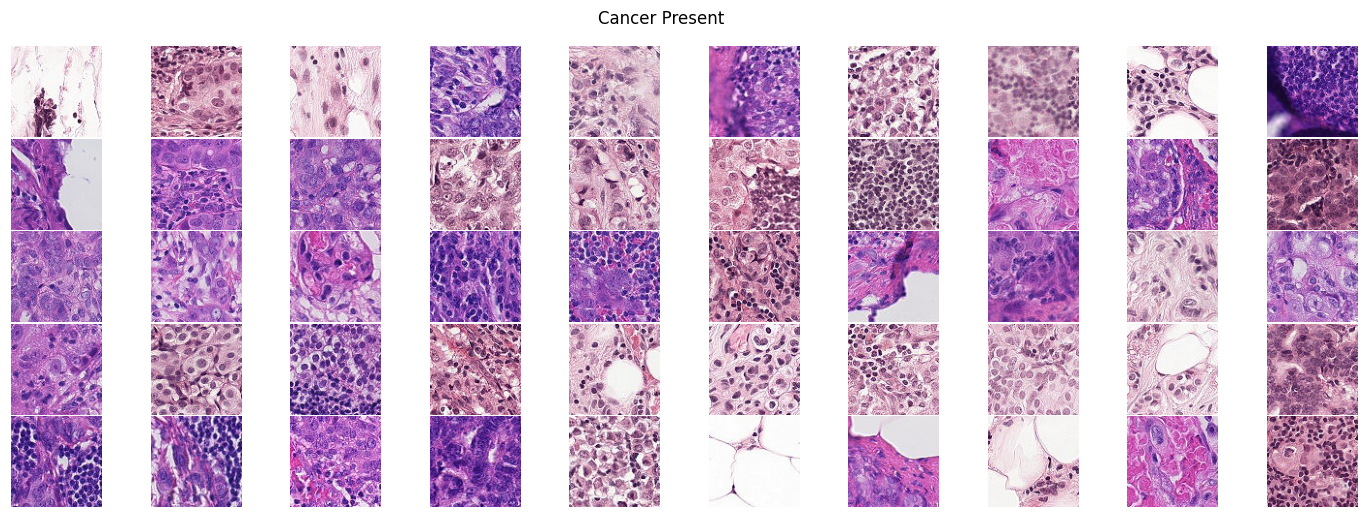

In [73]:
plot_fig(cancer, "Cancer Present", train)

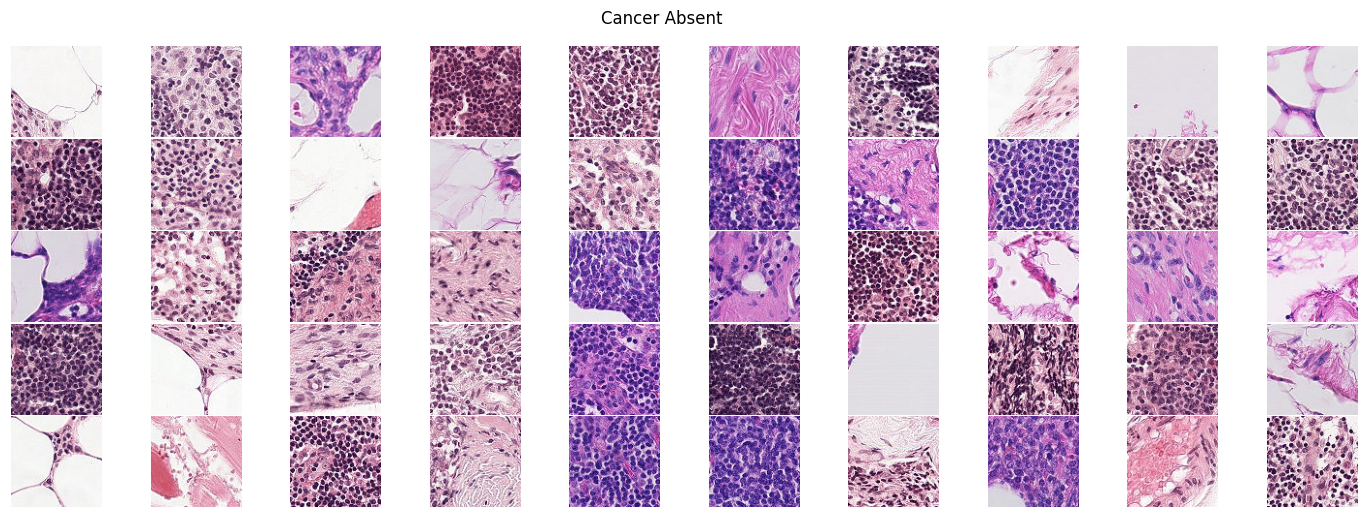

In [74]:
plot_fig(non_cancer, "Cancer Absent", train)

## Model Building

In [75]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,optimizers,models
from keras.metrics import AUC
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [76]:
train_labels = train_labels.astype(str)
train_labels['id'] += '.tif'
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train,  
    x_col="id",   
    y_col="label",      
    target_size=(96, 96),
    batch_size=32,
    class_mode="binary"  
)

Found 220025 validated image filenames belonging to 2 classes.


In [77]:
samples = samples.astype(str)
samples['id'] += '.tif'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=samples,
    directory=test,  
    x_col="id",   
    y_col="label",      
    target_size=(96, 96),
    batch_size=32, 
)

Found 57458 validated image filenames belonging to 1 classes.


In [78]:
def vgg_model(input_shape):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model
    
img_width, img_height = 96, 96
input_shape = (img_width, img_height, 3)
model = vgg_model(input_shape)

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(train_generator, batch_size=32, epochs=10)

prediction_labels = model.predict(test_generator)

/home/andrea/code/Intro to Deep Learning/linvenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,106,529 (8.04 MB)

 Trainable params: 2,106,529 (8.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/home/andrea/code/Intro to Deep Learning/linvenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 265/6876 ━━━━━━━━━━━━━━━━━━━━ 1:51 17ms/step - accuracy: 0.6051 - loss: 0.6844

2024-12-08 16:02:39.628543: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1014', 36 bytes spill stores, 40 bytes spill loads

2024-12-08 16:02:39.674281: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1014', 32 bytes spill stores, 32 bytes spill loads



6876/6876 ━━━━━━━━━━━━━━━━━━━━ 118s 17ms/step - accuracy: 0.5958 - loss: 0.6762
Epoch 2/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.5958 - loss: 0.6749
Epoch 3/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.5962 - loss: 0.6747
Epoch 4/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.5945 - loss: 0.6753
Epoch 5/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.5945 - loss: 0.6753
Epoch 6/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.5945 - loss: 0.6753
Epoch 7/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 63s 9ms/step - accuracy: 0.5956 - loss: 0.6749
Epoch 8/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.5944 - loss: 0.6753
Epoch 9/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 63s 9ms/step - accuracy: 0.5953 - loss: 0.6750
Epoch 10/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 64s 9ms/step - accuracy: 0.5966 - loss: 0.6744
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step


In [79]:
from sklearn.metrics import accuracy_score

predictions = (prediction_labels > 0.5).astype(int).flatten() 

true_labels = test_generator.labels 

# accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Test Accuracy: {accuracy}')

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_labels, predictions))
print(confusion_matrix(true_labels, predictions))

Test Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57458

    accuracy                           1.00     57458
   macro avg       1.00      1.00      1.00     57458
weighted avg       1.00      1.00      1.00     57458

[[57458]]


/home/andrea/code/Intro to Deep Learning/linvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


### Adding Dropout

In [80]:
from tensorflow.keras import regularizers

def vgg_model_2(input_shape):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # Dropout layer to prevent overfitting
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # Dropout layer to prevent overfitting
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # Dropout layer to prevent overfitting
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization
    model.add(layers.Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization
    model.add(layers.Dropout(0.5))  # Dropout layer to prevent overfitting
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

img_width, img_height = 96, 96
input_shape = (img_width, img_height, 3)
model_2 = vgg_model_2(input_shape)

learning_rate_2 = 0.001

optimizer_2 = Adam(learning_rate=learning_rate)

model_2.compile(optimizer=optimizer_2, loss='binary_crossentropy', metrics=['accuracy'])

model_2.summary()

history_2 = model_2.fit(train_generator, batch_size=32, epochs=10)

prediction_labels_2 = model.predict(test_generator)

/home/andrea/code/Intro to Deep Learning/linvenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,106,529 (8.04 MB)

 Trainable params: 2,106,529 (8.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 70s 10ms/step - accuracy: 0.5944 - loss: 0.7108
Epoch 2/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.5956 - loss: 0.6751
Epoch 3/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 64s 9ms/step - accuracy: 0.5945 - loss: 0.6754
Epoch 4/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 63s 9ms/step - accuracy: 0.5938 - loss: 0.6755
Epoch 5/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 64s 9ms/step - accuracy: 0.5940 - loss: 0.6754
Epoch 6/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 63s 9ms/step - accuracy: 0.5944 - loss: 0.6753
Epoch 7/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 63s 9ms/step - accuracy: 0.5963 - loss: 0.6745
Epoch 8/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.5968 - loss: 0.6743
Epoch 9/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.5926 - loss: 0.6759
Epoch 10/10
6876/6876 ━━━━━━━━━━━━━━━━━━━━ 64s 9ms/step - accuracy: 0.5938 - loss: 0.6754
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step


In [81]:
predictions_2 = (prediction_labels_2 > 0.5).astype(int).flatten() 

true_labels_2 = test_generator.labels 

# accuracy
accuracy_2 = accuracy_score(true_labels_2, predictions_2)
print(f'Test Accuracy: {accuracy_2}')

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_labels_2, predictions_2))
print(confusion_matrix(true_labels_2, predictions_2))

Test Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57458

    accuracy                           1.00     57458
   macro avg       1.00      1.00      1.00     57458
weighted avg       1.00      1.00      1.00     57458

[[57458]]


/home/andrea/code/Intro to Deep Learning/linvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


# Submittion file

In [82]:
# Apply a threshold of 50% to the predictions
binary_predictions = (predictions_2 > 0.5).astype(int)

# Create a DataFrame with the required format
submission_df = pd.DataFrame({
    'id': samples['id'].str.replace('.tif', ''),  # Remove the '.tif' extension
    'label': binary_predictions  # Use the binary predictions from the second model
})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

### Conclusion
While I achieved a max score of 50%, I learned a lot from this mini competition and will continue to develop this model and hope to get better accuracy with time.